# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries 
from pyspark.sql import DataFrame, SparkSession
import os
from os import listdir
import pandas as pd


# from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics
# import subprocess
import seaborn as sns
import matplotlib.pyplot  as plt
import datetime
import numpy as np
from pyspark.sql.window import Window
from pyspark.sql.functions import col, when, udf, regexp_replace,max,min,substring,countDistinct,desc,asc
from pyspark.sql import functions as F
from pyspark.sql.types import StringType,DateType,FloatType
from pyspark.sql import SQLContext
from pyspark.sql.types import StructType,StructField, StringType

In [2]:
# create a Spark session
spark= SparkSession.builder.getOrCreate()


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df=spark.read.json('mini_sparkify_event_data.json')
df.printSchema()
df.count()

    


root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



286500

Looking at the missing values in each column, we can see that there are a few missing values in columns such as artist,length etc.

In [57]:
miss_val=df.select([F.count(when(F.isnull(a), a)).alias(a) for a in df.columns])
missing_values=miss_val.toPandas()
missing_values
miss_val_per=df.select([(F.count(when(F.isnull(a), a))/F.count(F.lit(1))*100).alias(a) for a in df.columns])
missing_values_percent=miss_val_per.toPandas()
missing_values_percent
columns=[]
for col in df.columns:
    feature_nulls = df.filter(F.col(col).isNull()).count()
    if(feature_nulls>0):
        columns.append(col)
columns

['artist',
 'firstName',
 'gender',
 'lastName',
 'length',
 'location',
 'registration',
 'song',
 'userAgent']

Removing the blank user ids

In [4]:
df1=df.select( "userID", F.col("userID").cast("int").isNotNull().alias("Value"))
df1.filter(df1['Value']==False).count()

8346

In [5]:
df=df.select("*").where((df.userId != ""))
df.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Looking at the different variables/features

In [8]:
df.groupby("method").count().show()

+------+------+
|method| count|
+------+------+
|   PUT|257818|
|   GET| 20336|
+------+------+



The different page actions that a user has taken

In [9]:
df.groupby("page").count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



In [10]:
df.groupby("status").count().show()

+------+------+
|status| count|
+------+------+
|   307| 23184|
|   404|   252|
|   200|254718|
+------+------+



In [11]:
df.groupby("level").count().show()

+-----+------+
|level| count|
+-----+------+
| free| 55721|
| paid|222433|
+-----+------+



Creating our churn variable with page action = cancellation confirmation. Only 52 unique users have churned

In [6]:
# Only 52 users who churned.
df=df.withColumn("churn",when((col('page')=="Cancellation Confirmation"),1)
                 .otherwise(0))  

#Using window functions to get churn between timestamps

w = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding,Window.currentRow)
df=df.withColumn("all_churn", max("churn").over(w))


Looking at the timestamp(ts) variable to get a look at the activity of users across time. 

In [7]:
#Divide by 1000 because Javascript uses milliseconds internally, while normal UNIX timestamps are usually in seconds.
date_time_format_udf = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0),DateType())

In [9]:
df=df.withColumn('new_registration',date_time_format_udf('registration'))
df=df.withColumn('new_ts',date_time_format_udf('ts'))
# df=df.withColumn('new_ts',df.new_ts.cast('int'))
# df=df.withColumn('new_registration',df.new_registration.cast('int'))


In [22]:
df.select('new_ts').show(10)

+----------+
|    new_ts|
+----------+
|2018-10-01|
|2018-10-01|
|2018-10-01|
|2018-10-01|
|2018-10-01|
|2018-10-01|
|2018-10-01|
|2018-10-01|
|2018-10-01|
|2018-10-01|
+----------+
only showing top 10 rows



We can see that the number of songs played are highest between the 15th and 17th hours

In [138]:
daily_songs = df.select(['song','new_ts']).where(df.page=='NextSong').groupby('new_ts')\
             .agg(F.count('song')).withColumnRenamed('count(song)','Number of songs')\
             .withColumnRenamed('new_ts','Hours').orderBy('new_ts',descending=False).toPandas()



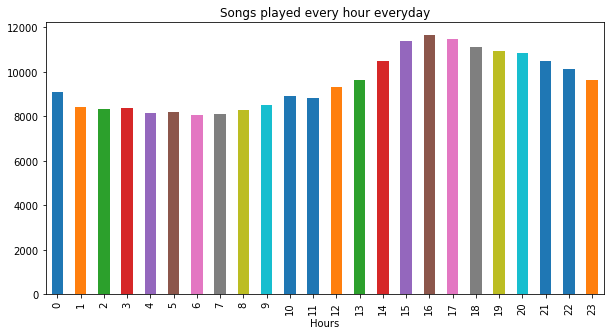

In [139]:
daily_songs.plot.bar(x='Hours', y='Number of songs',legend= None, stacked=True, width=0.5, figsize=(10, 5))
plt.title('Songs played every hour everyday');
plt.show()

Page Action next song is the highest followed by the thumbs up 

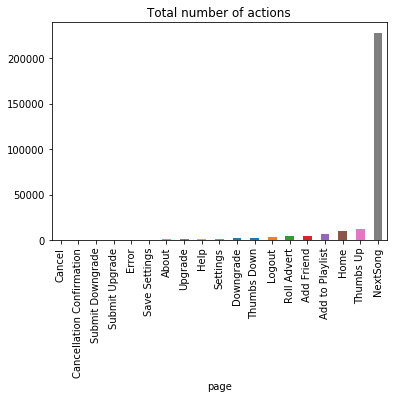

In [121]:
page_actions=df.groupby("page").count().sort("count",asc=False).toPandas()
page_actions.plot.bar(x='page', y='count', legend=None)
plt.title('Total number of actions');
plt.show()

In [122]:
# Top artists played
df.groupby('artist').count().orderBy("count",ascending=False).show(10)

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null|50046|
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
+--------------------+-----+
only showing top 10 rows



In [123]:
# Top songs played
df.groupby('song').count().orderBy("count",ascending=False).show(10)

+--------------------+-----+
|                song|count|
+--------------------+-----+
|                null|50046|
|      You're The One| 1153|
|                Undo| 1026|
|             Revelry|  854|
|       Sehr kosmisch|  728|
|Horn Concerto No....|  641|
|Dog Days Are Over...|  574|
|             Secrets|  466|
|        Use Somebody|  459|
|              Canada|  435|
+--------------------+-----+
only showing top 10 rows



In [49]:
# Number of NextSong actions taken by the 2 groups
df.filter(F.col('page')=="NextSong").groupBy('all_churn').count().show(2)

+---------+------+
|all_churn| count|
+---------+------+
|        1| 36394|
|        0|191714|
+---------+------+



We can see that the people who have a free account have had a higher churn rate than the people who have a paid account

In [125]:
# Percentage of people who churned who had free/paid accounts 
tot_free=df.filter(F.col('level')=="free").count()
free=df.filter(F.col('level')=="free").groupBy('all_churn')\
    .agg(F.count('all_churn')/tot_free*100).show()



+---------+----------------------------------+
|all_churn|((count(all_churn) / 55721) * 100)|
+---------+----------------------------------+
|        1|                22.232192530643744|
|        0|                 77.76780746935626|
+---------+----------------------------------+



In [126]:
tot_paid=df.filter(F.col('level')=="paid").count()
paid=df.filter(F.col('level')=="paid").groupBy('all_churn').agg(F.count('all_churn')/tot_paid*100).show()

+---------+-----------------------------------+
|all_churn|((count(all_churn) / 222433) * 100)|
+---------+-----------------------------------+
|        1|                 14.600351566539139|
|        0|                  85.39964843346087|
+---------+-----------------------------------+



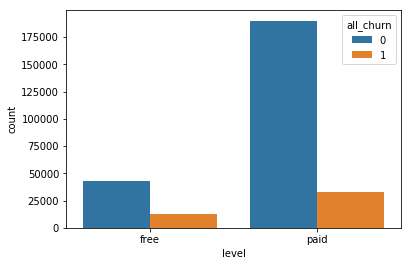

In [127]:
churn_level=df.groupby('all_churn','level').count().toPandas()
sns.barplot(data= churn_level, x='level', y='count', hue='all_churn')

Average number of songs played is higher when the customer has not churned

In [128]:
# average songs played in the two groups
churn_songs=df.filter(F.col('page')=="NextSong").groupBy('all_churn').agg(F.count('all_churn')/F.countDistinct('userID')).show()

+---------+-------------------------------------------+
|all_churn|(count(all_churn) / count(DISTINCT userID))|
+---------+-------------------------------------------+
|        1|                          699.8846153846154|
|        0|                         1108.1734104046243|
+---------+-------------------------------------------+



In [129]:
df=df.withColumn('thumbs_down',when((F.col('page')=='Thumbs Down'),'yes').otherwise('no'))
tud=df.groupby('all_churn','thumbs_down').count().show()

+---------+-----------+------+
|all_churn|thumbs_down| count|
+---------+-----------+------+
|        1|         no| 44368|
|        1|        yes|   496|
|        0|         no|231240|
|        0|        yes|  2050|
+---------+-----------+------+



We can see that the thumbs down rate is slightly higher for people who have churned

In [130]:
churn_count=df.filter(F.col('all_churn')==1).count()
down_percentage=df.filter(F.col('all_churn')==1).groupBy('thumbs_down').agg(F.count('all_churn')/churn_count*100)\
.withColumnRenamed('((count(all_churn) / 44864) * 100)','Thumbs down %').show()

+-----------+------------------+
|thumbs_down|     Thumbs down %|
+-----------+------------------+
|         no| 98.89443651925819|
|        yes|1.1055634807417976|
+-----------+------------------+



In [131]:
non_churn_count=df.filter(F.col('all_churn')==0).count()
down_percentage=df.filter(F.col('all_churn')==0).groupBy('thumbs_down').agg(F.count('all_churn')/non_churn_count*100)\
.withColumnRenamed('((count(all_churn) / 233290) * 100)','Thumbs down %').show()

+-----------+------------------+
|thumbs_down|     Thumbs down %|
+-----------+------------------+
|         no| 99.12126537785588|
|        yes|0.8787346221441126|
+-----------+------------------+



The number of males who churn is higher than the females

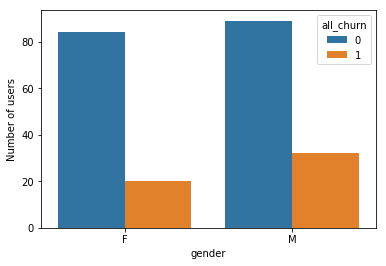

In [132]:
churn_gender = df.dropDuplicates(['userId']).groupby(['all_churn','gender']).agg(F.count('userId'))\
.withColumnRenamed('count(userId)','Number of users').toPandas()
sns.barplot(data = churn_gender, x='gender', y='Number of users', hue='all_churn')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [10]:
# creating a list of the feature page actions that I want as features
features_from_page_list = ['Downgrade','Thumbs Down', 'Thumbs Up', 'Add to Playlist', 
                            'Add Friend', 'Error', 'Home', 'Roll Advert']

In [11]:
# function to extract features from page
def extract_page_feature(df, page_action):
    
    '''
    This function creates individual page action features from the page column
    
    input:
    df- sparkify dataframe
    page_action-the page action taken by the user 
    
    output:
    page_feature- page_action feature
    
    '''
    
    page_feature= df.filter(df.page==page_action).groupby('userId').agg(F.count('page'))\
                  .withColumnRenamed('count(page)', page_action)
    return page_feature




In [12]:
# creating a dataframe for the features
df_page_features = df.select('userId').groupby('userId').count()
df_page_features.count()


225

In [13]:
for feature in features_from_page_list :
    page_feature = extract_page_feature(df, feature)
    df_page_features  = df_page_features.join(page_feature,'userId','outer')

In [14]:
# df_page_features.show()
df_page_features.count()

225

In [15]:
# Total songs listened to by the user
songs_feature= df.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'total_songs')
songs_feature.show()

+------+-----------+
|userId|total_songs|
+------+-----------+
|100010|        381|
|200002|        474|
|   125|         11|
|    51|       2464|
|   124|       4825|
|     7|        201|
|    54|       3437|
|    15|       2278|
|   155|       1002|
|   132|       2304|
|   154|        118|
|100014|        310|
|   101|       2149|
|    11|        848|
|   138|       2469|
|300017|       4428|
|    29|       3603|
|    69|       1342|
|100021|        319|
|    42|       4257|
+------+-----------+
only showing top 20 rows



In [16]:
#Gender
df=df.withColumn('gender_feat',when((col('gender')=='M'),1).otherwise(0))
gender_feature=df.select('userId', 'gender_feat').groupBy('userId')\
              .agg(max('gender_feat')).withColumnRenamed('max(gender_feat)','gender_feat')
gender_feature.show()

+------+-----------+
|userId|gender_feat|
+------+-----------+
|100010|          0|
|200002|          1|
|   125|          1|
|    51|          1|
|   124|          0|
|     7|          1|
|    54|          0|
|    15|          1|
|   155|          0|
|   132|          0|
|   154|          0|
|100014|          1|
|   101|          1|
|    11|          0|
|   138|          1|
|300017|          0|
|    29|          1|
|    69|          0|
|100021|          1|
|    42|          0|
+------+-----------+
only showing top 20 rows



In [17]:
#Level- free or paid
df=df.withColumn('level_feat',when((col('level')=='paid'),1).otherwise(0))
level_feature=df.select('userId', 'level_feat').groupBy('userId')\
              .agg(max('level_feat')).withColumnRenamed('max(level_feat)','level_feat')
level_feature.show()

+------+----------+
|userId|level_feat|
+------+----------+
|100010|         0|
|200002|         1|
|   125|         0|
|    51|         1|
|   124|         1|
|     7|         0|
|    54|         1|
|    15|         1|
|   155|         1|
|   132|         1|
|   154|         0|
|100014|         1|
|   101|         1|
|    11|         1|
|   138|         1|
|300017|         1|
|    29|         1|
|    69|         1|
|100021|         0|
|    42|         1|
+------+----------+
only showing top 20 rows



In [18]:
# What is the time since the user registered
df=df.withColumn('time_since_registration',(df.ts-df.registration))
# df.select('new_ts','new_registration','time_since_registration').show()
time_feature=df.select('userID','time_since_registration').groupBy('userID')\
             .agg(max('time_since_registration')).withColumnRenamed('max(time_since_registration)','time_since_reg_feature')
time_feature.show(5)

+------+----------------------+
|userID|time_since_reg_feature|
+------+----------------------+
|100010|            4807612000|
|200002|            6054448000|
|   125|            6161779000|
|    51|            1680985000|
|   124|           11366431000|
+------+----------------------+
only showing top 5 rows



In [19]:
total_artists_feature = df.filter(df.page == "NextSong").select("userId", "artist").dropDuplicates()\
                       .groupby("userId").count().withColumnRenamed("count", "total_artists_played_feat")

In [20]:
song_time_feature= df.select('userID','length').groupBy('userID').sum('length')\
                   .withColumnRenamed('sum(length)','listening_time_feat')

In [21]:
song_time_feature.show()

+------+-------------------+
|userID|listening_time_feat|
+------+-------------------+
|100010|  66940.89735000003|
|200002|  94008.87593999993|
|   125| 2089.1131000000005|
|    51|  523275.8428000004|
|   124| 1012312.0927899999|
|     7|  38034.08710000002|
|    54|  711344.9195400011|
|    15| 477307.60581000015|
|   155|        198779.2919|
|   132|  483118.9038399997|
|   154| 20660.023910000007|
|100014|  67703.47208000004|
|   101|  447464.0146699989|
|    11| 159669.96303999983|
|   138|  512449.8827599989|
|300017|  897406.9802100015|
|    29|  754517.5625700009|
|    69|  286064.0256399999|
|100021|  57633.17563999999|
|    42|  881792.9661300007|
+------+-------------------+
only showing top 20 rows



In [22]:
labels_data = df.groupBy('userId').agg(max('churn')).withColumnRenamed('max(churn)','churn')
# labels_data.count()


In [23]:
df_final=df_page_features.join(gender_feature,'userID','outer') \
    .join(level_feature,'userID','outer') \
    .join(time_feature,'userID','outer') \
    .join(total_artists_feature,'userID','outer') \
    .join(song_time_feature,'userID','outer') \
    .join(songs_feature,'userID','outer')\
    .join(labels_data,'userID','outer')\
    .drop('count') \
    .fillna(0)

In [24]:
# df_final.printSchema() 
# df_final.filter(col('churn')==1).select('churn').count()
df_final.columns

['userId',
 'Downgrade',
 'Thumbs Down',
 'Thumbs Up',
 'Add to Playlist',
 'Add Friend',
 'Error',
 'Home',
 'Roll Advert',
 'gender_feat',
 'level_feat',
 'time_since_reg_feature',
 'total_artists_played_feat',
 'listening_time_feat',
 'total_songs',
 'churn']

14 features that are taken as input features

In [25]:
# Features that I want to vectorize
vec_features =['Downgrade','Thumbs Down','Thumbs Up','Add to Playlist','Add Friend','Error','Home','Roll Advert','gender_feat',
           'level_feat','time_since_reg_feature','total_artists_played_feat','listening_time_feat','total_songs']


assembler = VectorAssembler(inputCols=vec_features, outputCol='vectorised_features')
final_df= assembler.transform(df_final)

In [26]:
scaler = StandardScaler(inputCol='vectorised_features',outputCol='vectorised_features_scaled')
scaler_model = scaler.fit(final_df)
final_df = scaler_model.transform(final_df)

In [27]:
final_data=final_df.select(final_df['vectorised_features_scaled'].alias("features"),final_df['churn'].alias("label"))

In [28]:
final_data.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,0.3823366215...|    0|
|[0.42609718619891...|    0|
|(14,[7,8,10,11,12...|    1|
|[3.49399692683107...|    0|
|[1.96004705651499...|    1|
|[0.0,0.0764673243...|    0|
|[2.38614424271390...|    0|
|[3.32355805235150...|    1|
|[1.02263324687738...|    0|
|[0.25565831171934...|    1|
|[1.61916930755586...|    0|
|[0.0,0.0,0.167995...|    0|
|[1.87482761927520...|    1|
|[0.42609718619891...|    0|
|[1.78960818203542...|    0|
|[2.13048593099455...|    0|
|[0.0,0.3823366215...|    1|
|[1.53394987031607...|    1|
|[0.76697493515803...|    0|
|[0.0,0.2294019729...|    0|
+--------------------+-----+
only showing top 20 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

Splitting the data into a 70:30 split of train and test datasets as it was found to be the best split

In [33]:
train,test=final_data.randomSplit([0.7, 0.3], seed=100)

Three models were used for the classification problem
1. Logistic Regression
2. Random Forest
3. XGBoost

# logistic regression model

In [34]:
# Build the model
log_reg=LogisticRegression(elasticNetParam=0.1)

# using F1-score as the classification evalution metric
f1_score_evaluator=MulticlassClassificationEvaluator(metricName='f1')

# Building the Parameters bounds
parameter_grid_lr=ParamGridBuilder()\
            .addGrid(log_reg.regParam,[0.0, 0.1])\
            .addGrid(log_reg.maxIter,[10, 30])\
            .build()

# Performing cross-validation
cross_validation_lr=CrossValidator(estimator=log_reg,estimatorParamMaps=parameter_grid_lr,
                                      evaluator=f1_score_evaluator,numFolds=2)



In [31]:
# Training the model
lr=cross_validation_lr.fit(train)

# Fitting the model on test dataset
lr_predictions=lr.transform(test)


In [32]:
# Calculating f1-score to check performance of the logistic model
f1_metric_score_lr=f1_score_evaluator.evaluate(lr_predictions)

# Random Forest

In [35]:
random_forest = RandomForestClassifier()

parameter_grid_rf=ParamGridBuilder()\
            .addGrid(random_forest.numTrees, [20, 30])\
            .addGrid(random_forest.maxDepth, [10, 20]) \
            .build()

cross_validation_rf=CrossValidator(estimator=random_forest,estimatorParamMaps=parameter_grid_rf,
                                      evaluator=f1_score_evaluator,numFolds=2)




In [36]:
rf=cross_validation_rf.fit(train)

rf_predictions=rf.transform(test)

f1_metric_score_rf = f1_score_evaluator.evaluate(rf_predictions)


# XGBoost

In [37]:
gradient_booster=GBTClassifier(maxIter=10,seed=100)

parameter_grid_gbt=ParamGridBuilder()\
          .addGrid(gradient_booster.maxDepth,[5, 10])\
          .build()

cross_validation_gbt=CrossValidator(estimator=gradient_booster,estimatorParamMaps=parameter_grid_gbt,
                          evaluator=f1_score_evaluator,
                          numFolds=2)


In [38]:
gbt=cross_validation_gbt.fit(train)

gbt_predictions=rf.transform(test)

f1_metric_score_gbt = f1_score_evaluator.evaluate(gbt_predictions)

# Feature importances for xgboost

It was found that the below parameters were the best for the xgboost model

In [45]:
gbt_next = GBTClassifier(maxDepth=10,maxIter=10,seed=100)
gbt_model = gbt_next.fit(train)
# results = gbt_model.transform(test)
gbt_model.featureImportances

SparseVector(14, {0: 0.0199, 1: 0.1911, 2: 0.106, 3: 0.1015, 4: 0.1016, 5: 0.0067, 6: 0.0636, 7: 0.1608, 9: 0.0, 10: 0.2449, 11: 0.0039, 12: 0.0, 13: 0.0})

Text(0.5,1,'Boosted Trees importance scores')

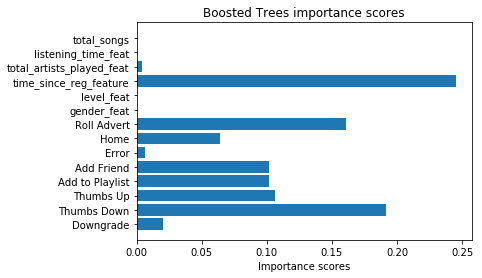

In [46]:
features=['Downgrade','Thumbs Down','Thumbs Up','Add to Playlist','Add Friend','Error','Home',
           'Roll Advert','gender_feat','level_feat','time_since_reg_feature','total_artists_played_feat'
           ,'listening_time_feat','total_songs']
# importance = [0.0705,0.1869,0.101,0.0368,0.1815,0.0045,0.0878,0.1266,0,0,0.1566,0.0432,0,0.0046]
importance_1=[0.0199,0.1911,0.106, 0.1015,0.1016,0.0067,0.0636,0.1608,0,0,0.2449,0.0039,0,0.0]

y_axis=np.arange(len(features))
          
        
plt.barh(y_axis,importance_1)
plt.yticks(y_axis,features)
plt.xlabel('Importance scores')
plt.title('Boosted Trees importance scores')


Features like Thumbs up, Thumbs down and time since registration contribute the most

# F1 scores and False positive rate for the respective models
Looking at the F1 score, both Random forest and gradient boosting models perform equally well. 

In [43]:
print('F1-Score for Logistic Regression model is: {}'.format(round(f1_metric_score_lr*100,2)))
print('F1-Score for Random Forest model is: {}'.format(round(f1_metric_score_rf*100,2)))
print('F1-Score for Gradient Boosting model is: {}'.format(round(f1_metric_score_gbt*100,2)))

F1-Score for Logistic Regression model is: 71.23
F1-Score for Random Forest model is: 74.52
F1-Score for Gradient Boosting model is: 74.52


In [42]:
preds_and_labels_1 = lr_predictions.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')
preds_and_labels_2 = rf_predictions.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')
preds_and_labels_3 = gbt_predictions.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels_1 = preds_and_labels_1.select(['prediction','label'])
preds_and_labels_2 = preds_and_labels_2.select(['prediction','label'])
preds_and_labels_3 = preds_and_labels_3.select(['prediction','label'])

metrics_1 = MulticlassMetrics(preds_and_labels_1.rdd.map(tuple))
metrics_2 = MulticlassMetrics(preds_and_labels_2.rdd.map(tuple))
metrics_3 = MulticlassMetrics(preds_and_labels_3.rdd.map(tuple))

# print(metrics.confusionMatrix().toArray())
# print(metrics.accuracy)
print('False positive rate for Logistic Regression model is:{}'.format(metrics_1.falsePositiveRate(1.0)))
print('False positive rate for Random Forest model is:{}'.format(metrics_2.falsePositiveRate(1.0)))
print('False positive rate for Gradient Boosting model model is:{}'.format(metrics_3.falsePositiveRate(1.0)))

False positive rate for Logistic Regression model is:0.07142857142857142
False positive rate for Random Forest model is:0.09523809523809523
False positive rate for Gradient Boosting model model is:0.09523809523809523


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.